In [1]:
pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

# Library Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV

# Library Handling Imbalance
from imblearn.over_sampling import SMOTE

# Library Model Klasifikasi
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Library Evaluasi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Konfigurasi
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# 1. Load Data
filename = 'Data Profil Kesehatan Indonesia 2014-2024 (New 2).xlsx'
df = pd.read_excel(filename)

# Menampilkan info dasar
print(f"Jumlah Baris & Kolom Awal: {df.shape}")
print("Kolom yang tersedia:")
print(df.columns.tolist())

Jumlah Baris & Kolom Awal: (382, 13)
Kolom yang tersedia:
['Tahun', 'Provinsi', 'Jumlah Kasus TBC per 100000 Penduduk', 'Treatment Success Rate Kasus TBC (%)', 'Persentase Penduduk Miskin (%)', 'IPM', 'Kepadatan Penduduk per km2', 'Persentase Kabupaten/Kota Sehat (%)', 'Persentase Cakupan Imunisasi Dasar Lengkap Pada Bayi Menurut Provinsi (%)', 'Jumlah Sarana Produksi Bidang Kefarmasian dan Alat Kesehatan', 'Rasio Puskemas per Kecamatan', 'Jumlah Rumah Sakit Menurut Provinsi', 'Persentase Rumah Tangga Yang Memiliki Akses Terhadap Sanitasi Layak Menurut Provinsi (%)']


In [4]:
print(df.head())
df.info()

   Tahun        Provinsi  Jumlah Kasus TBC per 100000 Penduduk  \
0   2014            Aceh                                   110   
1   2014  Sumatera Utara                                   141   
2   2014  Sumatera Barat                                   134   
3   2014            Riau                                    75   
4   2014           Jambi                                    90   

   Treatment Success Rate Kasus TBC (%)  Persentase Penduduk Miskin (%)  \
0                                  47.5                           16.98   
1                                  90.6                            9.85   
2                                  88.3                            6.89   
3                                  84.4                            7.99   
4                                  71.5                            8.39   

     IPM  Kepadatan Penduduk per km2  Persentase Kabupaten/Kota Sehat (%)  \
0  68.81                       81.64                                 8.70  

In [5]:
print("\nStatistik Deskriptif (df.describe()):")
print(df.describe())


Statistik Deskriptif (df.describe()):
             Tahun  Jumlah Kasus TBC per 100000 Penduduk  \
count   382.000000                            382.000000   
mean   2019.094241                            193.269634   
std       3.199658                            109.388340   
min    2014.000000                             48.000000   
25%    2016.000000                            121.000000   
50%    2019.000000                            165.500000   
75%    2022.000000                            236.750000   
max    2024.000000                            927.000000   

       Treatment Success Rate Kasus TBC (%)  Persentase Penduduk Miskin (%)  \
count                            381.000000                       377.00000   
mean                              82.797874                        10.81878   
std                               10.528389                         5.70692   
min                               26.400000                         3.47000   
25%                      

In [6]:
print("\nPengecekan Nilai Hilang (df.isnull().sum()):")
print(df.isnull().sum())


Pengecekan Nilai Hilang (df.isnull().sum()):
Tahun                                                                                       0
Provinsi                                                                                    0
Jumlah Kasus TBC per 100000 Penduduk                                                        0
Treatment Success Rate Kasus TBC (%)                                                        1
Persentase Penduduk Miskin (%)                                                              5
IPM                                                                                         4
Kepadatan Penduduk per km2                                                                  0
Persentase Kabupaten/Kota Sehat (%)                                                         0
Persentase Cakupan Imunisasi Dasar Lengkap Pada Bayi Menurut Provinsi (%)                   0
Jumlah Sarana Produksi Bidang Kefarmasian dan Alat Kesehatan                                1
Rasio Puskemas

In [7]:
# 2. Sorting Data (SANGAT KRUSIAL)
# Data harus urut Provinsi lalu Tahun agar interpolasi & lagging valid
df = df.sort_values(by=['Provinsi', 'Tahun'])

In [8]:
# 3. Imputasi Missing Value
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_impute = [col for col in numeric_cols if col not in ['Tahun']]

for col in cols_to_impute:
    df[col] = df.groupby('Provinsi')[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())

In [9]:
# Duplicates
initial_rows = len(df)
df = df.drop_duplicates()
removed = initial_rows - len(df)
if removed > 0: print(f"✓ Dihapus {removed} baris duplikat")
else: print("✓ Tidak ada duplikasi")

✓ Tidak ada duplikasi


In [10]:
# ==============================================================================
# ## --- CLUSTERING --- ##
# ==============================================================================
target_col = 'Jumlah Kasus TBC per 100000 Penduduk'
X_cluster = df[[target_col]].values
scaler_cluster = MinMaxScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

Menampilkan Grafik Elbow...


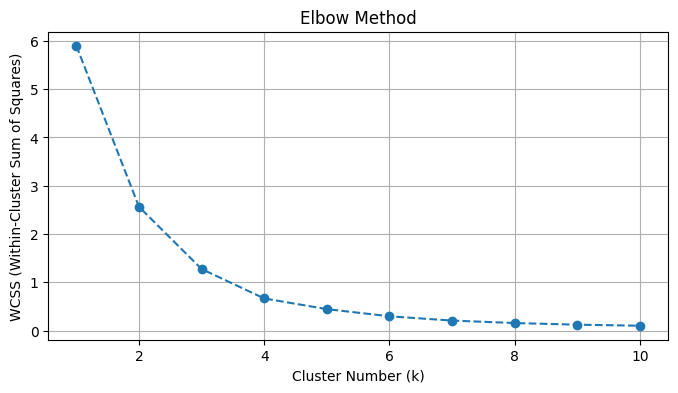

In [11]:
# --- LANGKAH A: ELBOW METHOD ---
print("Menampilkan Grafik Elbow...")
wcss = []
k_range = range(1, 11)
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Cluster Number (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [12]:
# --- LANGKAH B: RUN K-MEANS ---
k_pilihan = 3
kmeans = KMeans(n_clusters=k_pilihan, init='k-means++', random_state=42, n_init=10)
df['Cluster_Label'] = kmeans.fit_predict(X_cluster_scaled)

In [13]:
# A. Hitung rata-rata target per cluster dan URUTKAN (Sort) dari kecil ke besar
cluster_stats = df.groupby('Cluster_Label')[target_col].mean().sort_values()
print("\nStatistik Rata-rata per Cluster (Sorted):")
print(cluster_stats)


Statistik Rata-rata per Cluster (Sorted):
Cluster_Label
0    127.201835
1    243.421429
2    500.833333
Name: Jumlah Kasus TBC per 100000 Penduduk, dtype: float64


In [14]:
# B. Buat Dictionary Mapping Otomatis
# Logic: Cluster dengan rata-rata terkecil diberi kode 0, dst.
# enumerate() akan memberi indeks 0, 1, 2 pada hasil sort di atas
auto_mapping = {label_lama: label_baru for label_baru, label_lama in enumerate(cluster_stats.index)}

print(f"\nMapping Terbentuk Otomatis: {auto_mapping}")
# Contoh Output: {1: 0, 0: 1, 2: 2} -> Artinya Cluster 1 diubah jadi 0 (Rendah)


Mapping Terbentuk Otomatis: {0: 0, 1: 1, 2: 2}


In [15]:
# C. Terapkan Mapping
df['Risk_Code'] = df['Cluster_Label'].map(auto_mapping)

In [16]:
# D. Beri Nama Kategori
risk_names = {0: 'Green Zone', 1: 'Yellow Zone', 2: 'Red Zone'}
df['Risk_Category'] = df['Risk_Code'].map(risk_names)

print("\nValidasi Hasil Mapping (Harus urut dari Rendah ke Tinggi):")
print(df.groupby('Risk_Category')[target_col].mean().sort_values())


Validasi Hasil Mapping (Harus urut dari Rendah ke Tinggi):
Risk_Category
Green Zone     127.201835
Yellow Zone    243.421429
Red Zone       500.833333
Name: Jumlah Kasus TBC per 100000 Penduduk, dtype: float64


In [17]:
# ==============================================================================
# 3. MENAMPILKAN JUMLAH WILAYAH PER CLUSTER
# ==============================================================================
print("\n" + "="*50)
print("JUMLAH DATA PER CLUSTER (TOTAL 2014-2024)")
print("="*50)

# Hitung jumlah
counts = df['Risk_Category'].value_counts().sort_index()

for category, count in counts.items():
    print(f"{category:<20} : {count} Data Wilayah")

print("-" * 50)
print(f"TOTAL DATA           : {len(df)}")
print("-" * 50)


JUMLAH DATA PER CLUSTER (TOTAL 2014-2024)
Green Zone           : 218 Data Wilayah
Red Zone             : 24 Data Wilayah
Yellow Zone          : 140 Data Wilayah
--------------------------------------------------
TOTAL DATA           : 382
--------------------------------------------------


In [18]:
# ==============================================================================
# ## --- TAHAP 3: LAGGING & PREPARATION --- ##
# ==============================================================================
print("\n>>> [TAHAP 3] FEATURE ENGINEERING (LAGGING)")
ignore_cols = ['Tahun', 'Provinsi', 'Cluster_Label', 'Risk_Code', 'Risk_Category']
feature_cols = [col for col in df.columns if col not in ignore_cols]

for col in feature_cols:
    df[f'{col}_prev'] = df.groupby('Provinsi')[col].shift(1)
df_model = df.dropna().reset_index(drop=True)


>>> [TAHAP 3] FEATURE ENGINEERING (LAGGING)


In [19]:
# ==============================================================================
# 2. MENAMPILKAN INFORMASI DATASET FINAL
# ==============================================================================
print("\n" + "="*80)
print(">>> INFORMASI DATASET FINAL (SIAP UNTUK MODELING)")
print("="*80)

# A. Dimensi Data
print(f"1. Jumlah Baris: {df_model.shape[0]}")
print(f"2. Jumlah Kolom: {df_model.shape[1]}")
print(f"   (Baris berkurang karena tahun pertama setiap provinsi dihapus)")

# B. Cek Missing Value Final
total_nan = df_model.isnull().sum().sum()
print(f"3. Sisa Missing Value: {total_nan} (Harus 0)")

# C. Tampilan 5 Baris Teratas
print("\n4. Sample 5 Baris Data Final:")
# Kita hanya tampilkan kolom Identitas, Target, dan beberapa Fitur Lagging agar muat di layar
preview_cols = ['Tahun', 'Provinsi', 'Risk_Category'] + [f'{feature_cols[0]}_prev', f'{feature_cols[1]}_prev']
print(df_model[preview_cols].head())

# D. VERIFIKASI LOGIKA LAGGING (PENTING!)
print("\n" + "="*80)
print(">>> VERIFIKASI LOGIKA TIME LAG (t vs t-1)")
print("Mengecek apakah kolom '_prev' benar-benar berisi data tahun lalu...")
print("="*80)

# Ambil contoh 1 Provinsi, misal 'Jawa Barat' (atau provinsi pertama di data)
sample_prov = df['Provinsi'].unique()[0]
print(f"Sample Provinsi: {sample_prov}")

# Ambil satu fitur contoh, misal fitur pertama di list
sample_feature = feature_cols[0]
lagged_feature = f"{sample_feature}_prev"

# Tampilkan data Asli (df) vs Data Model (df_model)
check_df = df[df['Provinsi'] == sample_prov][['Tahun', sample_feature, lagged_feature]].head(5)

print(f"\nFitur yang dicek: {sample_feature}")
print(check_df)

print("\nCARA MEMBACA TABEL DI ATAS:")
print("1. Lihat Kolom 'Tahun'.")
print(f"2. Nilai '{lagged_feature}' pada tahun 2015 HARUS SAMA dengan")
print(f"   nilai '{sample_feature}' pada tahun 2014.")
print("3. Baris tahun 2014 pasti NaN di kolom _prev (karena tidak ada data 2013).")
print("   Oleh karena itu, baris 2014 dihapus di dataset final (df_model).")


>>> INFORMASI DATASET FINAL (SIAP UNTUK MODELING)
1. Jumlah Baris: 344
2. Jumlah Kolom: 27
   (Baris berkurang karena tahun pertama setiap provinsi dihapus)
3. Sisa Missing Value: 0 (Harus 0)

4. Sample 5 Baris Data Final:
   Tahun Provinsi Risk_Category  Jumlah Kasus TBC per 100000 Penduduk_prev  \
0   2015     Aceh    Green Zone                                      110.0   
1   2016     Aceh    Green Zone                                      119.0   
2   2017     Aceh    Green Zone                                      114.0   
3   2018     Aceh    Green Zone                                      139.0   
4   2019     Aceh    Green Zone                                      151.0   

   Treatment Success Rate Kasus TBC (%)_prev  
0                                      47.50  
1                                      80.80  
2                                      79.30  
3                                      86.73  
4                                      85.48  

>>> VERIFIKASI LOGIKA TI

In [20]:
# ==============================================================================
# ## --- Split Data --- ##
# ==============================================================================
print("\n" + "="*80)
print(">>> Data Split")
print("="*80)

# Definisi X (Fitur t-1) dan y (Label t)
input_features = [f'{col}_prev' for col in feature_cols]
X = df_model[input_features]
y = df_model['Risk_Code']

# Split Data (80% Train, 20% Test)
# Stratify=y wajib agar proporsi kelas seimbang
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


>>> Data Split


In [21]:
# ==============================================================================
# ## --- TAHAP 4A: HANDLING IMBALANCE (SMOTE) --- ##
# ==============================================================================
print("\n" + "="*80)
print(">>> [TAHAP 4A] MENERAPKAN SMOTE (Synthetic Minority Over-sampling Technique)")
print("="*80)

print("Distribusi Data Training Sebelum SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nDistribusi Data Training Setelah SMOTE:")
print(y_train_balanced.value_counts())
print("(Sekarang jumlah data tiap kelas menjadi seimbang)")


>>> [TAHAP 4A] MENERAPKAN SMOTE (Synthetic Minority Over-sampling Technique)
Distribusi Data Training Sebelum SMOTE:
Risk_Code
0    148
1    109
2     18
Name: count, dtype: int64

Distribusi Data Training Setelah SMOTE:
Risk_Code
0    148
1    148
2    148
Name: count, dtype: int64
(Sekarang jumlah data tiap kelas menjadi seimbang)


In [22]:
# ==============================================================================
# ## --- TAHAP 5A: MODELING --- ##
# ==============================================================================
print("\n" + "="*80)
print(">>> [TAHAP 5] MODELING")
print("="*80)

# Inisialisasi Model
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
}

results = []
fitted_models = {} # Untuk menyimpan model baseline yang sudah dilatih

for name, model in models.items():
    # Train pada data balanced (SMOTE)
    model.fit(X_train_balanced, y_train_balanced)
    fitted_models[name] = model # Simpan model yang sudah fit

    # Predict pada data test asli (tidak di-SMOTE)
    y_pred = model.predict(X_test)

    # Hitung Metrik
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
# 2. Format Tampilan Menjadi Persentase (String %)
# Kita gunakan fungsi lambda untuk mengubah format 0.8523 -> 85.23%
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    df_results[col] = df_results[col].apply(lambda x: f"{x:.2%}")

print("Hasil Evaluasi Model :")
print(df_results)


>>> [TAHAP 5] MODELING
Hasil Evaluasi Model :
           Model Accuracy Precision  Recall F1-Score
3       LightGBM   75.36%    75.80%  75.36%   75.54%
1  Random Forest   73.91%    75.87%  73.91%   74.50%
0  Decision Tree   72.46%    76.28%  72.46%   73.07%
2        XGBoost   69.57%    71.28%  69.57%   70.24%


In [23]:
# ==============================================================================
# ## --- MEMILIH MODEL TERBAIK (AUTOMATIC SELECTION) --- ##
# ==============================================================================
# Cari model dengan Akurasi tertinggi dari dataframe hasil evaluasi
best_row = df_results.iloc[0] # Baris pertama pasti terbaik karena sudah di-sort
best_model_name = best_row['Model']
best_model_acc = best_row['Accuracy']
best_model_prec = best_row['Precision']
best_model_rec = best_row['Recall']
best_model_f1 = best_row['F1-Score']

# Ambil objek model yang sebenarnya dari dictionary 'fitted_models'
best_model_object = fitted_models[best_model_name]

print(f"\n🏆 MODEL TERBAIK YANG AKAN DIPAKAI: {best_model_name}")
print(f"   Akurasi: {best_model_acc}")
print(f"   Precision: {best_model_prec}")
print(f"   Recall: {best_model_rec}")
print(f"   F1-Score: {best_model_f1}")


🏆 MODEL TERBAIK YANG AKAN DIPAKAI: LightGBM
   Akurasi: 75.36%
   Precision: 75.80%
   Recall: 75.36%
   F1-Score: 75.54%



>>> [TAHAP 6] SHAP ANALYSIS (LightGBM)


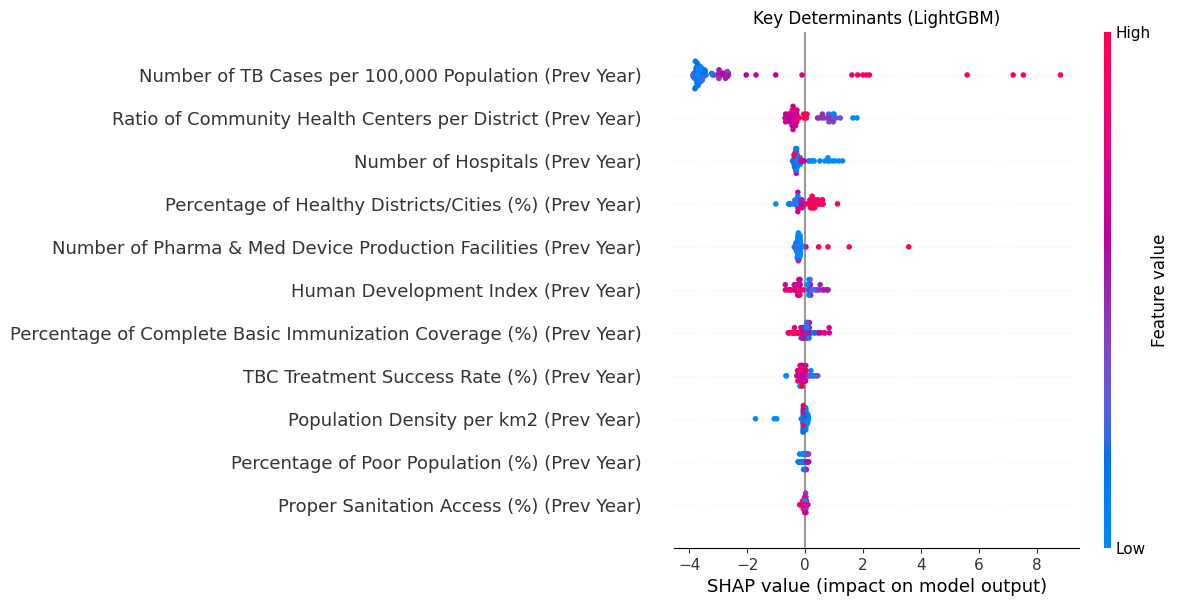

In [52]:
# ==============================================================================
# ## --- REVISI TAHAP 5: INTERPRETASI GLOBAL (SHAP SUMMARY) --- ##
# ==============================================================================
print("\n" + "="*80)
print(f">>> [TAHAP 6] SHAP ANALYSIS ({best_model_name})")
print("="*80)

tree_models = ["Random Forest", "XGBoost", "LightGBM", "Decision Tree"]

# 1. DEFINISI KAMUS TRANSLASI (Indonesia -> Inggris)
# Sesuaikan key (kiri) dengan nama kolom asli di dataset Anda
translation_map = {
    "Tahun": "Year",
    "Jumlah Kasus TBC per 100000 Penduduk": "Number of TB Cases per 100,000 Population",
    "Treatment Success Rate Kasus TBC (%)": "TBC Treatment Success Rate (%)",
    "Persentase Penduduk Miskin (%)": "Percentage of Poor Population (%)",
    "IPM": "Human Development Index",
    "Kepadatan Penduduk per km2": "Population Density per km2",
    "Persentase Kabupaten/Kota Sehat (%)": "Percentage of Healthy Districts/Cities (%)",
    "Persentase Cakupan Imunisasi Dasar Lengkap Pada Bayi Menurut Provinsi (%)": "Percentage of Complete Basic Immunization Coverage (%)",
    "Jumlah Sarana Produksi Bidang Kefarmasian dan Alat Kesehatan": "Number of Pharma & Med Device Production Facilities",
    "Rasio Puskemas per Kecamatan": "Ratio of Community Health Centers per District",
    "Jumlah Rumah Sakit Menurut Provinsi": "Number of Hospitals",
    "Persentase Rumah Tangga Yang Memiliki Akses Terhadap Sanitasi Layak Menurut Provinsi (%)": "Proper Sanitation Access (%)"
}

# Jika Anda menggunakan Model Lagged (Tahun Sebelumnya), tambahkan logika ini:
# Code ini otomatis menambahkan "_prev" ke kamus bahasa Inggris jika fitur Anda pakai "_prev"
translation_map_final = translation_map.copy()
for key, val in translation_map.items():
    translation_map_final[f"{key}_prev"] = f"{val} (Prev Year)"

if best_model_name in tree_models:
    try:
        # 2. BUAT DATASET VISUALISASI (RENAME KOLOM)
        # Kita copy X_test agar data asli tidak berubah, lalu rename kolomnya
        X_test_viz = X_test.rename(columns=translation_map_final)

        # Inisialisasi Explainer
        explainer = shap.TreeExplainer(best_model_object)

        # Hitung SHAP Values dari Data Test
        shap_values = explainer.shap_values(X_test, check_additivity=False)

        # Logika Pengambilan SHAP Values (List vs Array)
        if isinstance(shap_values, list):
            target_idx = -1
            sv_target = shap_values[target_idx]
        else:
            if len(shap_values.shape) == 3:
                sv_target = shap_values[:, :, -1]
            else:
                sv_target = shap_values

        plt.figure(figsize=(12,18)) # Ukuran diperbesar sedikit agar teks jelas

        # 3. GUNAKAN X_test_viz (YANG SUDAH DI-INGGRIS-KAN) UNTUK PLOTTING
        shap.summary_plot(sv_target, X_test_viz, plot_size=(12,6), show=False)

        plt.title(f"Key Determinants ({best_model_name})", fontsize=12)
        plt.xlabel("SHAP value (impact on model output)")
        plt.show()

    except Exception as e:
        print(f"SHAP Error: {e}")
        print("Tips: Coba update library shap dengan 'pip install --upgrade shap'")
else:
    print(f"Model {best_model_name} bukan Tree-based, melewati SHAP Analysis.")

In [25]:
# ==============================================================================
# ## --- TAHAP 6: DEPLOYMENT & DIAGNOSA MASA DEPAN (2025) --- ##
# ==============================================================================
print("\n" + "="*80)
print(">>> [TAHAP 7] PREDIKSI & DIAGNOSA TAHUN 2025")
print("="*80)

last_year = df['Tahun'].max()
future_year = last_year + 1
latest_data = df[df['Tahun'] == last_year].copy()

# Siapkan Input 2024 (sebagai t-1 untuk 2025)
X_future = latest_data[feature_cols]
X_future.columns = input_features # Rename ke _prev

# Prediksi menggunakan Model Terbaik
pred_code = best_model_object.predict(X_future)
latest_data['Prediksi_2025'] = [risk_names[c] for c in pred_code]
latest_data['Kode_Prediksi'] = pred_code

print(f"Hasil Prediksi Risiko TBC Tahun {future_year} per Provinsi:")
print(latest_data[['Provinsi', 'Prediksi_2025']])


>>> [TAHAP 7] PREDIKSI & DIAGNOSA TAHUN 2025
Hasil Prediksi Risiko TBC Tahun 2025 per Provinsi:
                      Provinsi Prediksi_2025
344                       Aceh   Yellow Zone
360                       Bali    Green Zone
359                     Banten      Red Zone
350                   Bengkulu    Green Zone
357              DI Yogyakarta    Green Zone
354                DKI Jakarta      Red Zone
372                  Gorontalo      Red Zone
348                      Jambi    Green Zone
355                 Jawa Barat      Red Zone
356                Jawa Tengah   Yellow Zone
358                 Jawa Timur   Yellow Zone
363           Kalimantan Barat   Yellow Zone
365         Kalimantan Selatan   Yellow Zone
364          Kalimantan Tengah    Green Zone
366           Kalimantan Timur   Yellow Zone
367           Kalimantan Utara   Yellow Zone
352  Kepulauan Bangka Belitung    Green Zone
353             Kepulauan Riau      Red Zone
351                    Lampung   Yellow Zone
374


🚨 DIAGNOSA KEBIJAKAN KHUSUS: PROVINSI DKI JAKARTA
Menganalisis alasan kenapa provinsi ini diprediksi MERAH...


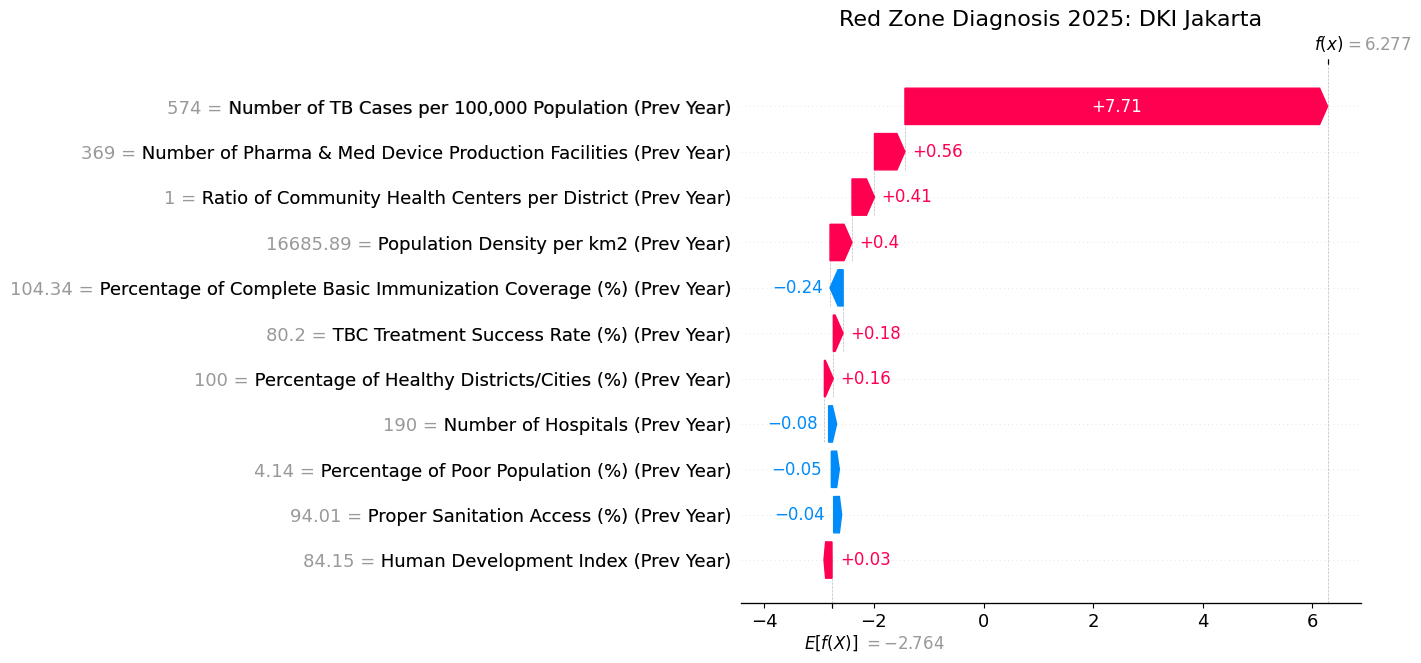

📝 RECOMMENDATION FOR LOCAL GOVERNMENT:
   1. RED Bar to RIGHT = Driving Factors (Pushing TBC Cases UP).
   2. BLUE Bar to LEFT = Resisting Factors (Pulling TBC Cases DOWN).
   3. Prioritize fixing the factors with the longest RED bars.

>>> SELESAI. SYSTEM READY. <<<


In [54]:
import matplotlib.pyplot as plt
import shap

# ==============================================================================
# ## --- 1. DEFINISI MAPPING TRANSLASI (FULL ENGLISH) --- ##
# ==============================================================================
translation_map = {
    "Tahun": "Year",
    "Jumlah Kasus TBC per 100000 Penduduk": "Number of TB Cases per 100,000 Population",
    "Treatment Success Rate Kasus TBC (%)": "TBC Treatment Success Rate (%)",
    "Persentase Penduduk Miskin (%)": "Percentage of Poor Population (%)",
    "IPM": "Human Development Index",
    "Kepadatan Penduduk per km2": "Population Density per km2",
    "Persentase Kabupaten/Kota Sehat (%)": "Percentage of Healthy Districts/Cities (%)",
    "Persentase Cakupan Imunisasi Dasar Lengkap Pada Bayi Menurut Provinsi (%)": "Percentage of Complete Basic Immunization Coverage (%)",
    "Jumlah Sarana Produksi Bidang Kefarmasian dan Alat Kesehatan": "Number of Pharma & Med Device Production Facilities",
    "Rasio Puskemas per Kecamatan": "Ratio of Community Health Centers per District",
    "Jumlah Rumah Sakit Menurut Provinsi": "Number of Hospitals",
    "Persentase Rumah Tangga Yang Memiliki Akses Terhadap Sanitasi Layak Menurut Provinsi (%)": "Proper Sanitation Access (%)",
}

# LOGIKA _PREV: Tambahkan versi "_prev" ke kamus agar fitur lagged juga ter-translate
translation_map_final = translation_map.copy()
for key, val in translation_map.items():
    translation_map_final[f"{key}_prev"] = f"{val} (Prev Year)"


# ==============================================================================
# ## --- 2. STUDI KASUS: DIAGNOSA PROVINSI ZONA MERAH (WATERFALL) --- ##
# ==============================================================================
# Filter provinsi yang diprediksi Zona Merah (Kode 2)
red_zone_provs = latest_data[latest_data['Kode_Prediksi'] == 2]

if not red_zone_provs.empty and best_model_name in tree_models:
    # Ambil 1 provinsi sampel pertama yang merah
    sample_prov = red_zone_provs.iloc[1] # Menggunakan iloc[0] agar aman jika hanya ada 1 provinsi
    prov_name = sample_prov['Provinsi']

    print(f"\n🚨 DIAGNOSA KEBIJAKAN KHUSUS: PROVINSI {prov_name.upper()}")
    print("Menganalisis alasan kenapa provinsi ini diprediksi MERAH...")

    try:
        # Hitung SHAP value object (Explanation) untuk data masa depan
        explainer_viz = shap.TreeExplainer(best_model_object)
        shap_obj = explainer_viz(X_future)

        # Cari index row provinsi tersebut di dalam X_future / latest_data
        idx_prov = list(latest_data.index).index(sample_prov.name)

        # Tentukan slice untuk kelas 'Tinggi'
        class_idx = -1 # Default ambil kelas terakhir (High Risk)

        # Handling dimensi shap_obj untuk waterfall
        # shap_obj bisa 2D (Regression) atau 3D (Classification)
        if len(shap_obj.shape) == 3:
            explanation = shap_obj[idx_prov, :, class_idx]
        else:
            explanation = shap_obj[idx_prov]

        # --- [BAGIAN PENTING: TERAPKAN TRANSLASI] ---
        # Kita ganti nama fitur di objek 'explanation' sebelum di-plot
        new_feature_names = [translation_map_final.get(name, name) for name in explanation.feature_names]
        explanation.feature_names = new_feature_names
        # --------------------------------------------

        # Plot Waterfall
        plt.figure(figsize=(14, 8)) # Ukuran disesuaikan agar teks bahasa Inggris muat
        shap.plots.waterfall(explanation, max_display=12, show=False)

        plt.title(f"Red Zone Diagnosis 2025: {prov_name}", fontsize=16)
        plt.tight_layout()
        plt.show()

        print("📝 RECOMMENDATION FOR LOCAL GOVERNMENT:")
        print("   1. RED Bar to RIGHT = Driving Factors (Pushing TBC Cases UP).")
        print("   2. BLUE Bar to LEFT = Resisting Factors (Pulling TBC Cases DOWN).")
        print("   3. Prioritize fixing the factors with the longest RED bars.")

    except Exception as e:
        print(f"Gagal membuat Waterfall Plot: {e}")

elif red_zone_provs.empty:
    print(f"\n✅ KABAR BAIK: Tidak ada provinsi yang diprediksi masuk Zona Merah di tahun {future_year}.")
else:
    print("\nVisualisasi Waterfall dilewati (Model Non-Tree atau Library Issue).")

print("\n>>> SELESAI. SYSTEM READY. <<<")